In [1]:
import sys
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

root_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(root_dir, 'src'))

from model import LaneNet, PostProcessor, LaneClustering
from dataloader import get_data_loader
from utils import get_lane_area, get_lane_mask

%matplotlib inline

# Set up model location

In [2]:
model_file = os.path.join(root_dir, 'output', 'model', 'lanenet.pth')
meta_file = os.path.join(root_dir, 'output', 'metadata', 'tusimple.json')

# Load model file and prepare data loader

In [3]:


checkpoint = torch.load(model_file)

checkpoint_opt = checkpoint['opt']

# Load model location
model = LaneNet(cnn_type=checkpoint_opt.cnn_type)

opt = {'batch_size': 2, 'meta_file': meta_file}
# Update/Overwrite some test options like batch size, location to metadata
# file
vars(checkpoint_opt).update(opt)

test_loader = get_data_loader(
    checkpoint_opt,
    split='test',
    return_raw_image=True)

model.load_state_dict(checkpoint['model'])

if torch.cuda.is_available():
    model.cuda()

postprocessor = PostProcessor()
clustering = LaneClustering()


# Test on test images

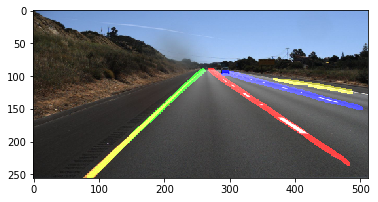

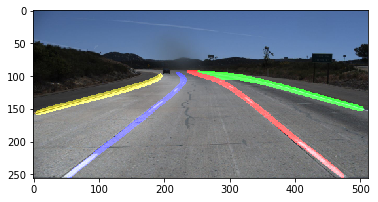

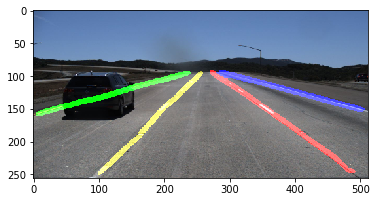

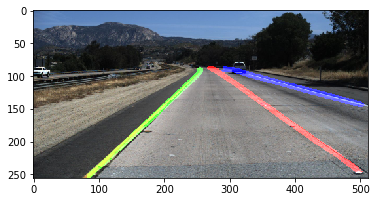

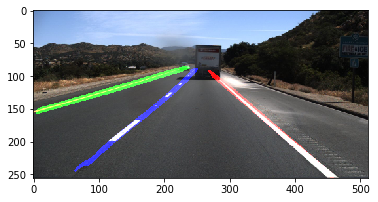

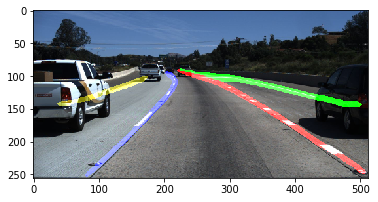

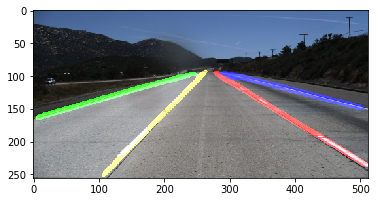

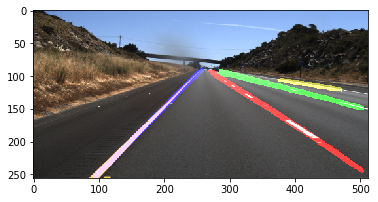

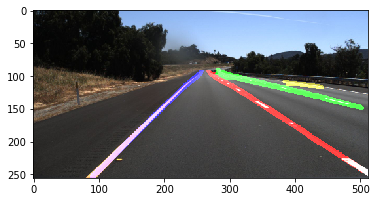

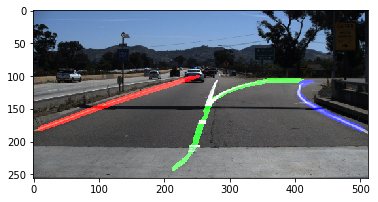

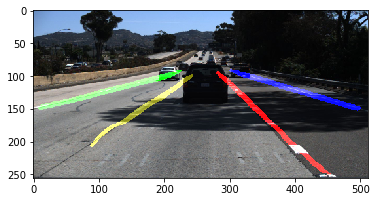

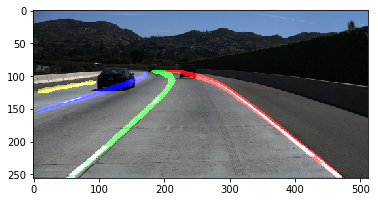

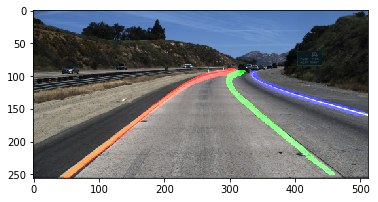

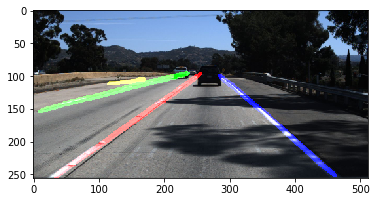

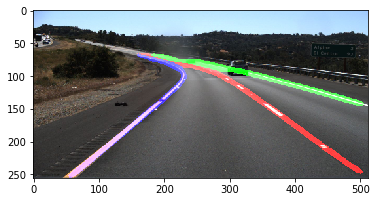

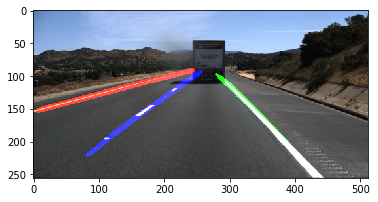

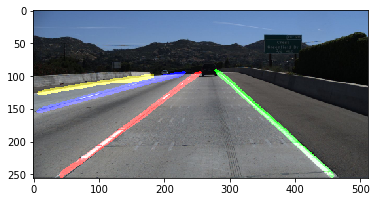

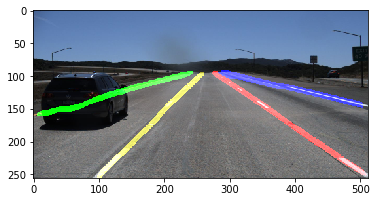

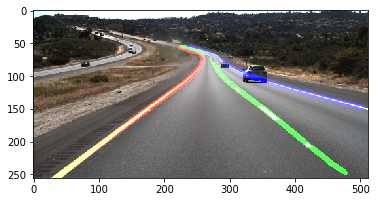

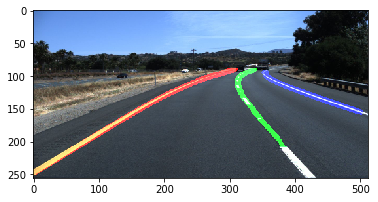

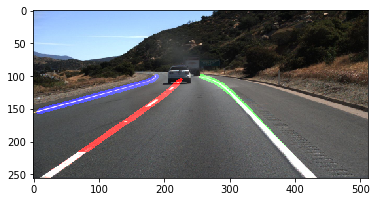

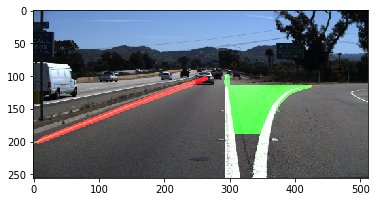

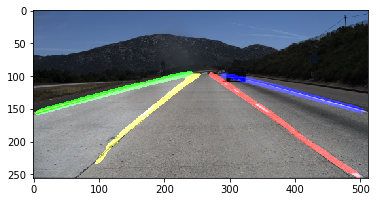

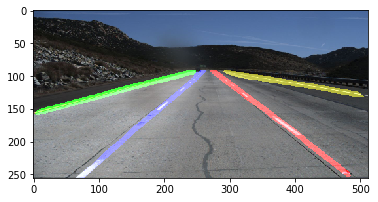

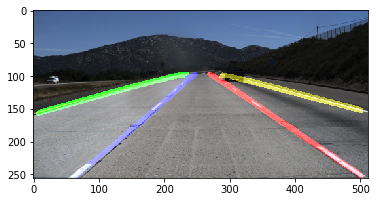

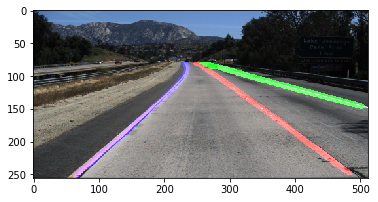

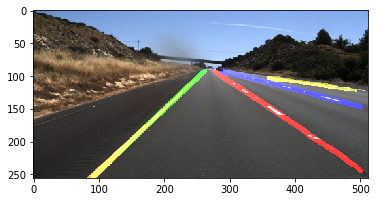

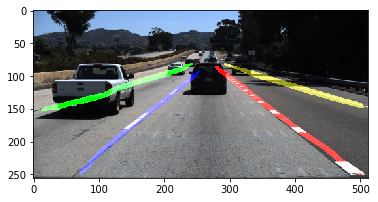

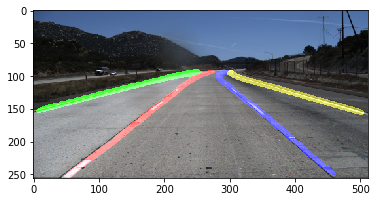

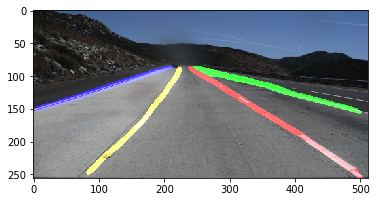

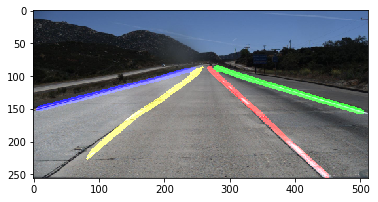

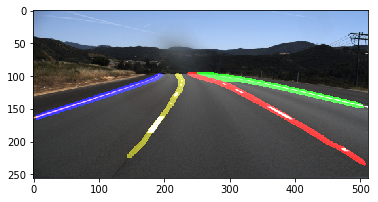

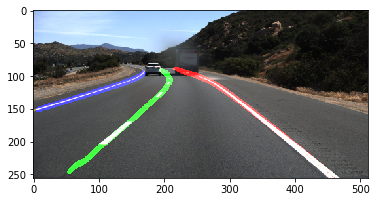

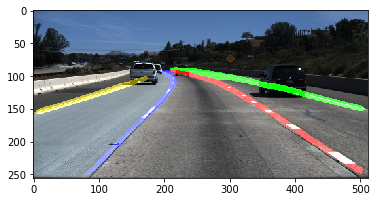

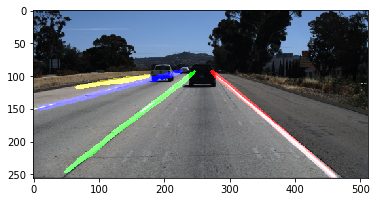

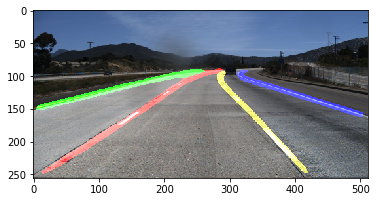

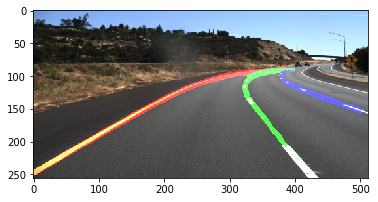

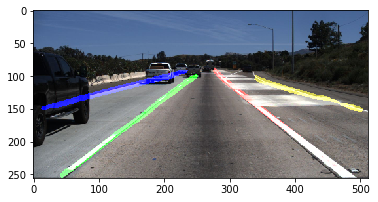

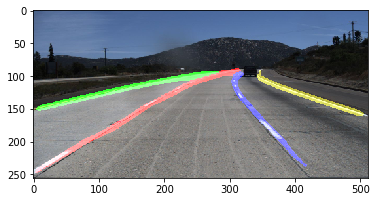

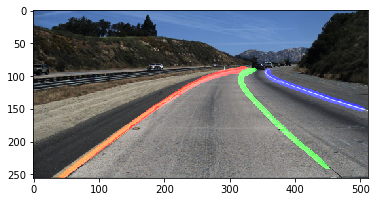

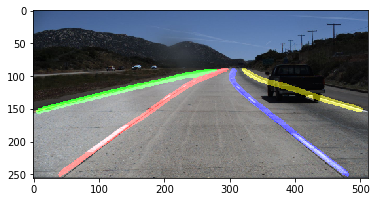

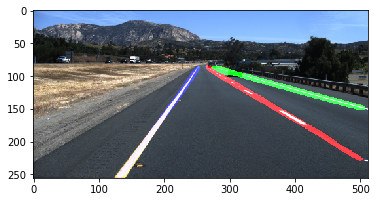

In [4]:
model.eval()

max_samples = 20
n_sample = 0
for data in test_loader:

    images, _, _, _, org_images = data

    images = Variable(images, volatile=False)

    if torch.cuda.is_available():
        images = images.cuda()

    bin_preds, ins_preds = model(images)

    # convert to probabiblity output
    bin_preds = F.softmax(bin_preds, dim=1)
    # take the index of the max along the dim=1 dimension
    bin_preds = bin_preds.max(1)[1]

    bs = images.shape[0]
    for i in range(0, bs):
        bin_img = bin_preds[i].data.cpu().numpy()
        ins_img = ins_preds[i].data.cpu().numpy()

        bin_img = postprocessor.process(bin_img)

        lane_embedding_feats, lane_coordinate = get_lane_area(
            bin_img, ins_img)

        num_clusters, labels, cluster_centers = clustering.cluster(
            lane_embedding_feats, bandwidth=1.5)

        mask_img = get_lane_mask(num_clusters, labels, bin_img,
                                 lane_coordinate)

        src_img = org_images[i]
        overlay_img = cv2.addWeighted(src_img, 1.0, mask_img, 1.0, 0)
        plt.imshow(overlay_img)
        plt.show()
        plt.pause(1)
        
    n_sample += 1
    if n_sample > max_samples:
        break